<a href="https://colab.research.google.com/github/seokjinwoo/AIandEcon/blob/main/lec11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Shrinkage 축소 기법

- 독립변수, features 특성변수가 아주 많을 때

- 특성변수 중 일부를 임의로 선택하거나, 체계적으로 선택해서 모형을 구축(subset selection). forward 혹은 backward.

- 계수의 추정치를 제한함(constrain).
- 계수의 추정치를 축소(shrink). 0으로 만들거나, 아니면 0에 가깝게 만든다.

- Ridge(능선) regression, Lasso(올가미) regression

### Ridge regression

- Least square: 잔차의 제곱의 합을 최소화 시킨다.
$$
\sum_{i=1}^n ( y_i - \beta_0 - \beta_1 x_{1i} - \cdots  - \beta_p x_{pi}  )^2
$$

- Ridge regression의 목적함수는 다음과 같음
$$
\sum_{i=1}^n ( y_i - \beta_0 - \beta_1 x_{1i} - \cdots  - \beta_p x_{pi}  )^2 + \lambda \| \beta \|_2
$$

$$
\sum_{i=1}^n ( y_i - \beta_0 - \beta_1 x_{1i} - \cdots  - \beta_p x_{pi}  )^2 + \lambda \sum_{i=1}^p \beta_i ^2  
$$











- $\lambda$를 튜딩 파라미터, 하이퍼 파라미터라고도 함
- $\lambda$는 모형 밖에서 주어짐.

- $\lambda = 0$ 이면, OLS 추정치가 되고
- $\lambda \rightarrow \infty$ 인 경우에는 $\beta$가 0으로 수렴함

- $\lambda$는 보통 교차검증(cross-validation)을 통해서 결정함.



### Lasso regressionb

- Ridge regression에서는 대체로 모든 특성변수가 포함이 됨
- 이런 문제에 대한 대안으로 Lasso

$$
\sum_{i=1}^n ( y_i - \beta_0 - \beta_1 x_{1i} - \cdots  - \beta_p x_{pi}  )^2 + \lambda \| \beta \|_1
$$

$$
\sum_{i=1}^n ( y_i - \beta_0 - \beta_1 x_{1i} - \cdots  - \beta_p x_{pi}  )^2 + \lambda \sum_{i=1}^p  | \beta_i |
$$







In [ ]:
### Ridge and lasso regression 훈련

import pandas as pd

pd.read_csv('/content/Hitters.csv').head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
# scikit-learn 에 있는 라이브러리 사용.

# Regression 이용해서 subset selection (foraward)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

Hitters = pd.read_csv('/content/Hitters.csv')
Hitters = Hitters.dropna()


# one-hot encoding
df = pd.get_dummies(Hitters, drop_first=True)


# y, X에 대해서 정의
y = df['Salary']
X = df.drop(columns=['Salary'])

# train, test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
    )

# 모형
model = LinearRegression()
n_splits = min(5, len(X_train))
sfs = SFS(
    estimator=model,
    k_features='best',
    forward=True,
    floating=False,
    scoring='r2',
    cv=n_splits,
    n_jobs=-1
)

# 훈련
sfs.fit(X_train, y_train)

# 결과 확인
selected_features = list(sfs.k_feature_names_)
print("선택된 특성변수: ", selected_features)





선택된 특성변수:  ['AtBat', 'Hits', 'HmRun', 'Walks', 'CHits', 'CRuns', 'CWalks', 'PutOuts', 'Division_W']


In [ ]:
### Ridge regression
### 계수값의 제곱이 페널티로 들어감

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# 특성의 표준화
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Ridge model 학습
ridge_model = Ridge(alpha = 1.0)
ridge_model.fit(X_train_scaled, y_train)

# test
y_pred_ridge = ridge_model.predict(X_test_scaled)

# metric
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("Ridge MSE: ", mse_ridge)


Ridge MSE:  130864.60740509053


In [ ]:
# lambda selection (tuning of the model)
# for many lambdas, choose the optimal one

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import numpy as np

lambda_values = np.logspace(-3, 3, 100)

cv_mse_scores = []

# 5-fold CV을 통해서 mse를 계산
for alpha in lambda_values:
    ridge_model = Ridge(alpha=alpha)
    mse_scores = -np.mean(cross_val_score(ridge_model, X_train_scaled, y_train,
                                          scoring='neg_mean_squared_error', cv=5))
    cv_mse_scores.append(mse_scores)


Text(0.5, 1.0, 'Cross-Validation MSE vs. Lambda')

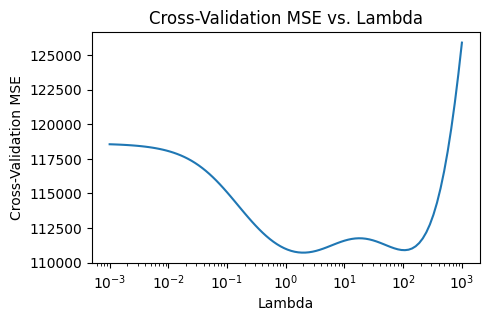

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(lambda_values, cv_mse_scores)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Cross-Validation MSE')
plt.title('Cross-Validation MSE vs. Lambda')

